<a href="https://colab.research.google.com/github/Phosics/ReinforcementLearningMidTermFlappyBird/blob/main/FlappyBirdMidTerm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installs

## Imports

In [1]:
!git clone https://github.com/ntasfi/PyGame-Learning-Environment
!pip install gym_ple
!pip install -e ./PyGame-Learning-Environment
!pip install pyvirtualdisplay
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev

Cloning into 'PyGame-Learning-Environment'...
remote: Enumerating objects: 1118, done.
remote: Total 1118 (delta 0), reused 0 (delta 0), pack-reused 1118 (from 1)
Receiving objects: 100% (1118/1118), 8.06 MiB | 25.15 MiB/s, done.
Resolving deltas: 100% (592/592), done.
  Preparing metadata (setup.py) ... done
  Created wheel for gym_ple: filename=gym_ple-0.3-py3-none-any.whl size=4458 sha256=6c2f10aa0ea85b35d1e23bb0afdea8d31e981bd928d6809153c78127ce97a95e
  Stored in directory: /root/.cache/pip/wheels/71/96/17/a59c56c130c89ad5816ef952c93cad65803807f1a3891ba994
Successfully built gym_ple
Obtaining file:///content/PyGame-Learning-Environment
  Preparing metadata (setup.py) ... done
  Running setup.py develop for ple
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libegl-dev libfontenc1 libgl-dev libgl1-mesa-dev 

In [34]:
import sys
sys.path.append('/content/PyGame-Learning-Environment')
from ple.games.flappybird import FlappyBird
from ple import PLE
from gym import spaces
import IPython
import numpy as np
import gym
import os
import pyvirtualdisplay
import base64
import warnings
import imageio
from abc import ABC, abstractmethod
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


## Utility function to display episode

In [4]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Environment

### Environment Summary

This environment simulates the *Flappy Bird* game, where the agent controls the bird’s vertical position to navigate through gaps in pipes. Built on OpenAI’s `gym.Env` class, the environment allows interaction through standard functions like `step`, `reset`, and `render`.

**Key Components**

- **Observation Space**: The observation space includes 8 integer values, each representing a different aspect of the game state. These include:
  - `"player_y"`: The bird's vertical position.
  - `"player_vel"`: The bird's vertical velocity.
  - `"next_pipe_dist_to_player"`: Horizontal distance to the next pipe.
  - Additional features: Positions of the top and bottom of the next two pipes, enabling the agent to anticipate upcoming gaps.

- **Action Space**: This is a discrete space with two actions:
  - `0`: No flap (bird falls due to gravity).
  - `1`: Flap (bird moves upward).
- **Using the Environment**

  - **Step:**
    The `step` function returns four parameters: `obs`, `reward`, `done`, and `info`.

    - **`obs`**: The new observation after applying the action.
    - **`reward`**: The reward received for the action.
    - **`done`**: A boolean indicating whether the episode has ended.
    - **`info`**: A dictionary containing additional information. In this environment, the `info` dictionary includes a `"score"` entry that indicates how many pipes the bird has passed since the beginning of the episode.
  - **Reset**
    The `reset` function restores the environment to its initial state and returns the observation of that state.

  - **Render**
    The `render` function returns an image of the current state as a NumPy array (`np.array`).

  See the `Running the environment` section below for an example of how to use it.

- **Customizable Parameters**:
  - **`pipe_gap`**: This controls the vertical gap between pipes. The default is set to `80`, providing a moderate challenge.
  - **`custom_obs`** and **`custome_observation_map`**: Setting `custom_obs=True` instructs the environment to use a custom `observation_map` specified by the user, rather than the default map. When using a custom observation map, the user must also provide a `preprocess` function compatible with the custom observation map to ensure the observations are correctly processed for the agent.

  - **`preprocess`** and **`reward_shaping`**: Optional functions that allow the user to customize how observations and rewards are modified. The `preprocess` function transforms the raw observations according to the specified `observation_map`, while `reward_shaping` allows for custom adjustments to the reward structure, helping to align the environment with the agent’s learning goals.

  See the `Custom observation and reward shaping example of usage` section below for an example of usage.






In [5]:
# to disable the python game window popup
os.environ["SDL_VIDEODRIVER"] = "dummy"

OBSERVATION_MAP = {0: 'player_y',
                   1: "player_vel",
                   2: "next_pipe_dist_to_player",
                   3: "next_pipe_top_y",
                   4: "next_pipe_bottom_y",
                   5: "next_next_pipe_dist_to_player",
                   6: "next_next_pipe_top_y",
                   7: "next_next_pipe_bottom_y",
}

class Game(gym.Env):
    def __init__(self, display_screen=False,
                 force_fps=True,
                 custom_obs=False,
                 pipe_gap=80,
                 custome_observation_map={},
                 preprocess=lambda x: x,
                 reward_shaping=lambda x, y, z: x):

        os.environ["SDL_VIDEODRIVER"] = "dummy"
        game = FlappyBird(pipe_gap=pipe_gap)  # define and initiate the environment
        self.env = PLE(game, fps=30, display_screen=display_screen,
                       force_fps=force_fps)
        self.env.init()
        # list of actions in the environment
        self.actions = self.env.getActionSet()
        # length of actions
        self.action_space = spaces.Discrete(len(self.actions))
        self.custom_obs = custom_obs
        self._observation_map = custome_observation_map if custom_obs else OBSERVATION_MAP
        self.preprocess = preprocess
        self.reward_shaping = reward_shaping
        self.score = 0

    @property
    def observation_space(self):
        return spaces.Box(low=0, high=512, shape=(len(self._observation_map),), dtype=int)

    def _get_rgb(self):
        return self.env.getScreenRGB().transpose(1, 0, 2)

    @property
    def observation_map(self):
        return self._observation_map

    def step(self, action):
        """Take the action chosen and update the reward"""
        reward = self.env.act(self.actions[action])
        if reward < 0:
          reward = -1

        if reward > 0:
          self.score += 1
        state = self.env.getGameState()
        terminal = self.env.game_over()
        reward = self.reward_shaping(reward, terminal, env)
        info = {'score':self.score}
        return self.preprocess(np.array(list(state.values())).astype(int)), reward, terminal, info

    def getGameState(self):
        '''
        PLEenv return gamestate as a dictionary. Returns a modified form
        of the gamestate only with the required information to define the state
        '''
        state = self.env.getGameState()
        h_dist = state['next_pipe_dist_to_player']
        v_dist = state['next_pipe_bottom_y'] - state['player_y']
        vel = state['player_vel']

        return ' '.join([str(vel), str(h_dist), str(v_dist)])

    def reset(self):
        """Resets the game to start a new game"""
        self.env.reset_game()
        state = self.env.getGameState()
        self.score = 0
        return self.preprocess(np.array(list(state.values())).astype(int))

    def render(self, mode='human'):
        """Render the game"""
        return self._get_rgb()

    def seed(self, seed):
        rng = np.random.RandomState(seed)
        self.env.rng = rng
        self.env.game.rng = self.env.rng

        self.env.init()

In [6]:
env = Game(custom_obs=False)

### Observation space

In [7]:
print(f"observation space: {env.observation_space}")
for feaure, des in env.observation_map.items():
  print(f"feaure: {feaure} -> {des}")

observation space: Box(0, 512, (8,), int64)
feaure: 0 -> player_y
feaure: 1 -> player_vel
feaure: 2 -> next_pipe_dist_to_player
feaure: 3 -> next_pipe_top_y
feaure: 4 -> next_pipe_bottom_y
feaure: 5 -> next_next_pipe_dist_to_player
feaure: 6 -> next_next_pipe_top_y
feaure: 7 -> next_next_pipe_bottom_y


In this *Flappy Bird* environment, the `Box` type represents a `Discrete` observation space in OpenAI's Gym, providing the agent with a range of values in each dimension of the environment. Here’s what each part means:

* **Box**: This type of space is used to define a `Discrete`  range of values for each observation dimension. Here, it represents an 8-dimensional vector.
* **(0, 512)**: Each dimension within this space can take values from 0 to 512, which corresponds to the pixel boundaries of the game.
* **(8,)**: This shape indicates that there are 8 distinct variables in the observation vector, each capturing a critical feature of the environment.
* **int64**: Each value in the vector is an integer of 64-bit precision.

In summary, `Box(0, 512, (8,), int64)` represents an 8-dimensional vector space where each element is an integer from 0 to 512. Each dimension corresponds to a specific aspect of the *Flappy Bird* environment:

1. **Player Y Position**: The vertical position of the bird, representing its height on the screen.
2. **Player Velocity**: The bird’s current velocity, which impacts its movement and helps determine when to flap.
3. **Distance to Next Pipe**: The horizontal distance between the bird and the next pipe, crucial for timing flaps.
4. **Next Pipe Top Y Position**: The vertical position of the top of the next pipe, helping the bird gauge the gap.
5. **Next Pipe Bottom Y Position**: The vertical position of the bottom of the next pipe, providing further data for navigating the gap.
6. **Distance to Next-Next Pipe**: The horizontal distance to the pipe after the next one, giving the bird foresight into upcoming obstacles.
7. **Next-Next Pipe Top Y Position**: The vertical position of the top of the pipe after the next one, extending the bird's view of upcoming gaps.
8. **Next-Next Pipe Bottom Y Position**: The vertical position of the bottom of the pipe after the next one, for additional planning.

Together, these dimensions offer the agent a detailed snapshot of the environment, helping it make decisions based on its position, velocity, and the layout of both current and upcoming obstacles.


### Action space

In [8]:
env.action_space

Discrete(2)

In this *Flappy Bird* environment, the `Discrete(2)` action space defines the possible actions the agent can take, using a finite set of discrete values:

* **Discrete**: This type of space is used when there are a limited number of distinct actions.
* **2**: The number of actions available, represented by values 0 and 1.

For *Flappy Bird*, these actions correspond to:
  * **0**: Do nothing (the bird continues to fall due to gravity).
  * **1**: Flap (the bird moves upward briefly).

In summary, `Discrete(2)` defines an action space with two possible actions: allowing the bird to either continue falling or flap to move upward, which is essential for navigating the gaps between pipes.


### Rewards

*Reward Structure:*



*   **Positive Reward**: For each pipe successfully passed, the agent receives a reward of **+1**.
*   **Negative Reward**: Upon reaching any terminal state, the agent receives a penalty of **-1**.
*   **Zero Reward**: Any other senario the reward is **0**




### Running the environmen

In [9]:
env = Game()
env.seed(42)
obs = env.reset()
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=24) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = env.action_space.sample()
      obs, reward, done, info = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      total_reward += reward
      re = env.render()
      video.append_data(re)
      if done:
        score = info['score']
        print("Sum of rewards =", total_reward, ", Number of steps=", step, "score: ", score)
        break
embed_mp4(video_filename)

Sum of rewards = -1.0 , Number of steps= 64 score:  0


### Custom observation and reward shaping example of usage

In [10]:
custom_obs_mapping = {0: "average",
                      1: 'sum'}

# meaningless preprocess method that average and sums all of the original features
preprocess = lambda x: np.array([np.mean(x), np.sum(x)])

# meaningless reward shaping method that added 1 to each original reward
reward_shaping = lambda x, y, z: x+1

env = Game(custom_obs=True,
           custome_observation_map=custom_obs_mapping,
           preprocess=preprocess,
           reward_shaping=reward_shaping)
env.seed(42)
obs = env.reset()

print(f"observation space: {env.observation_space}")
for feaure, des in env.observation_map.items():
  print(f"feaure: {feaure} -> {des}")

print(f"reset: {obs}")
print("#"*100, end="\n\n")
video_filename = '/content/vid.mp4'
max_steps = 100
# Evaluation
with imageio.get_writer(video_filename, fps=24) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = env.action_space.sample()
      obs, reward, done, info = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      total_reward += reward
      re = env.render()
      video.append_data(re)
      if done:
        score = info['score']
        print("Sum of rewards =", total_reward, ", Number of steps=", step, "score: ", score)
        break
embed_mp4(video_filename)

observation space: Box(0, 512, (2,), int64)
feaure: 0 -> average
feaure: 1 -> sum
reset: [ 197.5 1580. ]
####################################################################################################

Sum of rewards = 47.0 , Number of steps= 47 score:  0


# Your Work begins here

## Preprocess

**Define the `preprocess` Method**

- Create a function called `preprocess` that takes an observation as input.
- The purpose of this function is to transform the raw observation into a format that optimizes learning for the agent. Use your creativity to design an effective preprocessing strategy for this task.

**Suggested Approaches:**
- **Normalization or Scaling**: Adjust observation values to a common range, such as $0$ to $1$ or $0$ to $N$, to improve stability in the learning process.
- **Feature Extraction**: Emphasize key features in the observation that are crucial for achieving the environment's goals.
- **Dimensionality Reduction**: Simplify the observation by removing or combining less significant parts to streamline learning and reduce complexity.

**Compression and Q-Table Size**
- Reducing the complexity of the observation, through techniques like scaling, normalization, or removing redundant features, effectively compresses the data. This compression simplifies the agent’s perception of the environment, helping it focus on the most relevant information.
- In discrete environments, reducing observation dimensionality directly impacts the size of the Q-table. By compressing the observation space, you decrease the number of possible states, which makes the Q-table smaller and easier to manage. This reduction in Q-table size not only conserves memory but can also enhance learning efficiency.
  
Use these ideas to explain how your preprocessing strategy compresses the observation space and helps the agent handle the environment more effectively.

**Rationalize Your Preprocessing Choices**

- Include a brief explanation of your preprocessing choices. Explain why you believe this approach will improve the agent's learning efficiency and performance.
- Discuss how these adjustments make the observations more interpretable or manageable for the learning algorithm.

**Important**
- The maximum value on the **Vertical** axis is **512**.
- The maximum value on the **Horizontal** axis is **288**.


In [11]:
MIN_DISTANCE_VALUE = 0
MAX_DISTANCE_VALUE = 512

MIN_VELOCITY_VALUE = -512
MAX_VELOCITY_VALUE = 512

custome_observation_map = { 0: 'player_y_norm',
                            1: "player_vel_norm",
                            2: "next_pipe_dist_to_player_norm",
                            3: "next_pipe_top_y_norm",
                            4: "next_pipe_bottom_y_norm",
                            5: "next_next_pipe_dist_to_player_norm",
                            6: "next_next_pipe_top_y_norm",
                            7: "next_next_pipe_bottom_y_norm",
}
# assing each action with a description of the feature meaning

def normalize(value, min, max):
  return (value - min) / (max - min)

def normalize_distance(value):
  return normalize(value, MIN_DISTANCE_VALUE, MAX_DISTANCE_VALUE)

def normalize_velocity(value):
  return normalize(value, MIN_VELOCITY_VALUE, MAX_VELOCITY_VALUE)

def preprocess(obs):
  """
  insert your preprocessing code here
  """
  obs = obs.astype(float)
  obs[0] = normalize_distance(obs[0])
  obs[1] = normalize_velocity(obs[1])
  obs[2] = normalize_distance(obs[2])
  obs[3] = normalize_distance(obs[3])
  obs[4] = normalize_distance(obs[4])
  obs[5] = normalize_distance(obs[5])
  obs[6] = normalize_distance(obs[6])
  obs[7] = normalize_distance(obs[7])

  return obs

## Reward shaping

### Define a Reward Shaping Strategy

**Reward shaping** means adjusting the rewards given to the agent to encourage desired actions and help it learn faster. In *Flappy Bird*, the goal is to create rewards that guide the bird to survive longer and avoid hitting pipes.

**Steps for Reward Shaping:**

1. **Identify Desired Behaviors**:
   - Decide which behaviors you want to encourage. For example, flapping at the right time to pass through pipes or avoiding unnecessary flaps could be rewarded.

2. **Design Rewards**:
   - Use rewards that motivate the bird to take helpful actions without distracting from the main goal (staying alive). Here are some ideas:
     - **Survival Reward**: Give a small reward for each step the bird survives.
     - **Penalty for Hitting Pipes**: Apply a negative reward (penalty) when the bird crashes into a pipe.
    - **Passing Through Pipes**: Provide a positive reward each time the bird successfully passes through a pipe.


3. **Explain Your Reward Choices**:
   - Add an explanation for your reward design. Why did you decide to reward certain actions or apply penalties?
   - Describe how your rewards help the bird focus on staying alive and navigating pipes effectively.
   - Provide an example demonstrating the impact of your reward shaping logic, ideally by comparing performance graphs with and without reward shaping.

4. **Avoid Over-Shaping**:
   - Avoid giving too many rewards for minor actions, as it could lead the bird to focus on short-term rewards instead of the main goal. Aim for a balance where the bird gets enough guidance without relying on intermediate rewards.

**Q-Learning and Value Convergence**:
   - Remember, shaping rewards impacts **Q-values** (the expected value of actions). When rewards are well-designed, the bird’s Q-values will better reflect valuable actions, helping it make smarter choices over time.

Use these tips to develop a reward strategy that encourages the bird to navigate through pipes effectively while improving its learning.


In [12]:
def reward_shaping(reward, terminal, env):
  """
  insert your preprocessing code here
  """
  return reward

## Implementation of Learning Agents

Abstract Class for Implementing an On-Policy Agent

Below is an abstract class to serve as a foundation for implementing an on-policy agent. Derive your agent from this class and implement the specific logic for your agent. Note that different agents may require additional parameters or functions to support their unique features and learning mechanisms.


In [13]:
from abc import ABC, abstractmethod

class OnPolicyAgent(ABC):
    def __init__(self, action_space, observation_space, gamma, learning_rate):
        """
        Initializes the on-policy RL agent.
        You can add more parameters
        Parameters:
        - action_space: The action space of the environment
        - observation_space: The observation space of the environment
        - gamma: Discount factor for future rewards
        - learning_rate: Learning rate for policy updates
        """
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.policy = None  # Placeholder for policy (to be implemented in subclasses)

    @abstractmethod
    def select_action(self, observation, deterministic=False):
        """
        Select an action based on the current policy.

        Parameters:
        - observation: Current state observation from the environment
        -deterministic: Flag indicating whether to use a deterministic policy (default is False)
        Returns:
        - action: Chosen action based on the policy
        """
        pass

    @abstractmethod
    def update_policy(self, transition):
        """
        Update the policy based on the current transition.

        Parameters:
        - transition: Data collected from interactions with the environment (tuple of zero or more values such as acion, reward etc...)
        """
        pass

    @abstractmethod
    def train(self, env, num_episodes, log_every):
        """
        Train the agent over a specified number of episodes.

        Parameters:
        - env: The environment to train in
        - num_episodes: Number of training episodes
        """
        pass

    @abstractmethod
    def save_policy(self, file_path):
        """
        Save the current policy to a file.

        Parameters:
        - file_path: Path to the file where the policy should be saved
        """
        pass

    @abstractmethod
    def load_policy(self, file_path):
        """
        Load a policy from a file.

        Parameters:
        - file_path: Path to the file from which the policy should be loaded
        """
        pass

    @abstractmethod
    def run_policy(self, env):
        """
        Run the loaded policy in the environment for one episode.

        Parameters:
        - env: The environment in which to run the policy

        Returns:
        - total_reward: Total reward accumulated in the episode
        """
        pass


In [75]:
class QLearningAgent(OnPolicyAgent):
    def __init__(self, action_space, observation_space, video_filename, gamma=0.99, learning_rate=0.1, initial_q_values=0, epsilon=1, epsilon_decay=0.99, epsilon_min = 0.01, number_of_bins=10):
      super().__init__(action_space, observation_space, gamma, learning_rate)

      self.number_of_bins = number_of_bins
      self.epsilon = epsilon
      self.epsilon_decay = epsilon_decay
      self.epsilon_min = epsilon_min
      self.video_filename = video_filename

      self.construct_q_table(observation_space, action_space, initial_q_values)

    def construct_q_table(self, observation_space, action_space, initial_q_values):
      low = observation_space.low
      high = observation_space.high

      # Discretize the space
      bins = [np.linspace(low, high, self.number_of_bins + 1) for low, high in zip(low, high)]

      q_table_shape = tuple(len(b) - 1 for b in bins) + (action_space.n,)
      self.policy = np.full(q_table_shape, initial_q_values)

    def find_bin(self, value):
      bin = int(value / (1 / self.number_of_bins))

      if bin == self.number_of_bins:
        return bin - 1

      return bin

    def get_value(self, states, action=None):
      current_value = self.policy

      for state in states:
        current_value = current_value[self.find_bin(state)]

      if action is not None:
        current_value = current_value[action]

      return current_value

    def set_value(self, states, action, value):
      current_value = self.policy

      for state in states:
        current_value = current_value[self.find_bin(state)]

      current_value[action] = value

    def get_best_action(self, state):
      return np.argmax(self.get_value(state))

    def select_action(self, observation, deterministic=False):
      """Select an action using epsilon-greedy policy or the best action if deterministic."""
      if deterministic or np.random.rand() > self.epsilon:
          return self.get_best_action(observation)
      else:
          # Exploration: choose a random action
          return self.action_space.sample()

    def update_policy(self, transition):
        """
        Update Q-value based on the given transition.
        transition: (state, action, reward, next_state, done)
        """
        state, action, reward, next_state, done = transition

        # Extract the current Q-value
        current_q_value = self.get_value(state, action)

        # Extract the best possible action for the next state
        next_state_best_action = self.get_best_action(next_state)
        next_state_best_q_value = self.get_value(next_state, next_state_best_action)

        # Calcualte future reward
        if done:
          future_reward = 0
        else:
          future_reward = self.gamma * next_state_best_q_value

        # Calculate the Temporal Difference (TD)
        td_target = reward + future_reward

        # Calculate the TD error
        td_error = (reward + self.gamma * next_state_best_q_value) - current_q_value

        # Update the Q-value
        new_q_value = current_q_value + (self.learning_rate * td_error)
        self.set_value(state, action, new_q_value)

    def train(self, env, num_episodes, log_every=100):
        """
        Train the agent for the given number of episodes.
        """
        rewards = []
        scores = []

        avg_rewards = []
        avg_scores = []

        for episode in range(1, num_episodes + 1):
            state = env.reset()
            done = False
            total_reward = 0
            total_score = 0
            length = 0
            should_create_video = False

            if episode % log_every == 0:
              should_create_video = True
              video = imageio.get_writer(self.video_filename, fps=24)

            while not done:
                action = self.select_action(state)
                next_state, reward, done, info = env.step(action)

                # Update Q-table
                self.update_policy((state, action, reward, next_state, done))

                # Move to the next state
                state = next_state
                total_reward += reward
                total_score += info['score']
                # length += 1

                if should_create_video:
                  video.append_data(env.render())

            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            rewards.append(total_reward)
            scores.append(total_score)

            if episode % log_every == 0:
                video.close()
                avg_reward = np.mean(rewards)
                avg_score = np.mean(scores)
                print(f"Episode {episode}/{num_episodes}, Average Reward: {avg_reward:.2f}, Epsilon: {self.epsilon:.2f}, Average Score: {avg_score:.2f}")

                rewards.clear()
                scores.clear()

                avg_rewards.append(avg_reward)
                avg_scores.append(avg_score)

        return avg_rewards, avg_scores

    def save_policy(self, file_path):
        """Save Q-table to file (NumPy format)."""
        np.save(file_path, self.policy)

    def load_policy(self, file_path):
        """Load Q-table from file (NumPy format)."""
        self.policy = np.load(file_path)

    def run_policy(self, env):
        """
        Run the current policy (without exploration) for one episode and return the total reward.
        """
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            # Choose best action (deterministic)
            action = self.select_action(state, deterministic=True)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state

        return total_reward

## Training

#### Experimentation Instructions

In this section, you will conduct a series of experiments to solve the environment using your on-policy agent. Follow these guidelines for a clear and comprehensive presentation of your work:

1. **Design and Run Experiments**:
   - Perform at least **5 distinct experiments** with your agent, including:
     - **2 unsuccessful experiments** where the agent fails to learn the environment (reaching a score below the target).
     - **1 successful experiment** where the agent achieves a score of **10** or higher. (Remember the score is define by the amount of pipes the agent has passed)

   - *Note*: In practice, you are expected to try many configurations to observe various outcomes, even beyond these 3 experiments.

2. **Provide Detailed Summaries**:
   - For each experiment, include:
     - **Graphs** that illustrate the training process, such as reward progression, steps, score, and  any other relevant metrics (there is many more metrics that we can learn from).
     - **Explanations of Hyperparameters**: Clearly describe the configuration of hyperparameters chosen for each experiment, and the reasoning behind these choices.
     - **Preprocessing and Reward Shaping**: Explain any data preprocessing or reward shaping techniques applied, along with the motivation for these techniques.

3. **Analyze and Reflect**:
   - **Result Analysis**: Analyze each experiment's outcome, focusing on why the agent may have succeeded or failed based on your configurations.
   - **Insights and Deductions**: Draw insights from each experiment, noting what worked and what didn’t. Use these insights to refine your understanding of the environment and agent performance.

4. **Final Report**:
   - **Synthesize Findings**: Compile all observations, insights, and analysis from your experiments into a final report. This report should showcase your learnings and demonstrate a deep understanding of the experimentation process.
   - **Emphasis on Analysis**: The analysis of your results and the conclusions drawn are the most critical aspects of this exercise. Dedicate ample attention to this section, as it will reflect your ability to interpret and understand the agent’s learning process.

**Remember**: The goal of this exercise is to experiment, learn, and iterate. Document your process thoroughly, as this will form the foundation of your report.


In [73]:
# Hyper Parameters
GAMMA             = 0.99
LEARNING_RATE     = 0.01
INITIAL_Q_VALUES  = 0.001
EPSILON           = 1
EPSILON_DECAY     = 0.9999
MIN_EPSILON       = 0.01
NUMBER_OF_BINS    = 10

LOG_EVERY = 100
NUMBER_OF_EPISODES = 10000

reward_shaping = lambda x, y, z: x+1

In [76]:
env = Game(custom_obs=True, preprocess=preprocess, reward_shaping=reward_shaping, custome_observation_map=custome_observation_map)
"""
Insert you experiment code here
"""
video_filename = '/content/vid.mp4'
policy_agent = QLearningAgent(env.action_space, env.observation_space, video_filename, GAMMA, LEARNING_RATE, INITIAL_Q_VALUES, EPSILON, EPSILON_DECAY, MIN_EPSILON)
rewards, scores = policy_agent.train(env, NUMBER_OF_EPISODES, LOG_EVERY)

Episode 100/10000, Average Reward: 52.27, Epsilon: 0.99, Average Score: 0.17
Episode 200/10000, Average Reward: 52.56, Epsilon: 0.98, Average Score: 0.14
Episode 300/10000, Average Reward: 53.34, Epsilon: 0.97, Average Score: 0.02
Episode 400/10000, Average Reward: 51.76, Epsilon: 0.96, Average Score: 0.02
Episode 500/10000, Average Reward: 53.72, Epsilon: 0.95, Average Score: 0.16
Episode 600/10000, Average Reward: 53.74, Epsilon: 0.94, Average Score: 0.05
Episode 700/10000, Average Reward: 52.55, Epsilon: 0.93, Average Score: 0.04
Episode 800/10000, Average Reward: 50.72, Epsilon: 0.92, Average Score: 0.00
Episode 900/10000, Average Reward: 53.04, Epsilon: 0.91, Average Score: 0.03
Episode 1000/10000, Average Reward: 52.09, Epsilon: 0.90, Average Score: 0.02
Episode 1100/10000, Average Reward: 52.35, Epsilon: 0.90, Average Score: 0.00
Episode 1200/10000, Average Reward: 53.78, Epsilon: 0.89, Average Score: 0.00
Episode 1300/10000, Average Reward: 53.19, Epsilon: 0.88, Average Score: 

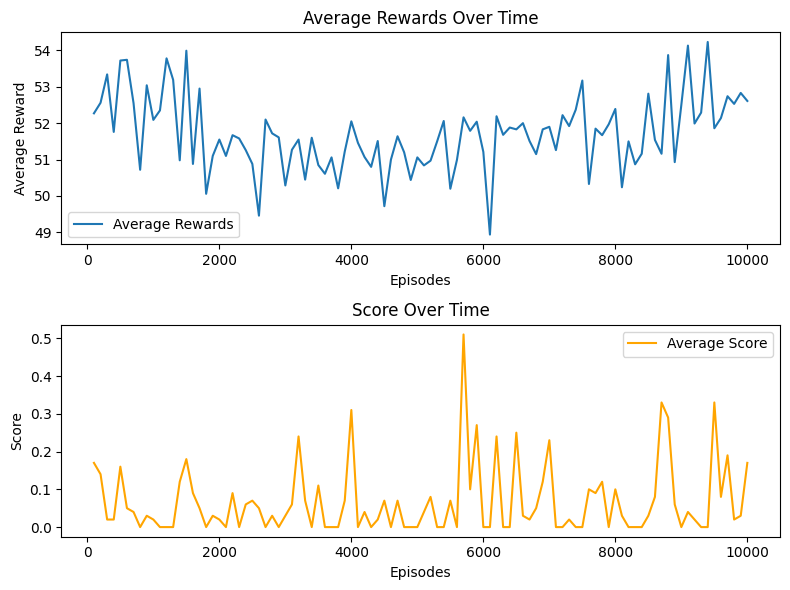

In [77]:
# Plot rewards and score
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Generate X-axis values (e.g., for every 100 episodes)
episodes = np.arange(LOG_EVERY, LOG_EVERY + len(rewards) * LOG_EVERY, LOG_EVERY)

# Plot rewards
axs[0].plot(episodes, rewards, label='Average Rewards')
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Average Reward')
axs[0].set_title('Average Rewards Over Time')
axs[0].legend()

#Plot scores
axs[1].plot(episodes, scores, label='Average Score', color='orange')
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Score')
axs[1].set_title('Score Over Time')
axs[1].legend()

plt.tight_layout()
plt.show()

In [78]:
embed_mp4(video_filename)

## Validation

#### Validation Section

In this section, you will validate your agent’s performance using the best-performing configuration identified in the experimentation phase. This validation step should be less exhaustive than the experimentation section but should provide sufficient evidence of your agent's consistency and stability.

1. **Run Validation Trials**:
   - Using the chosen configuration, run the agent in the environment for **multiple trials** (e.g., 5-10 episodes) to test its reliability.
   - Observe the agent's performance across these trials to confirm whether it consistently achieves or exceeds the target score of 10.

2. **Provide Key Summaries**:
   - **Performance Metrics**: Summarize the agent’s performance with key metrics such as average score, highest score, and variance across trials.
   - **Graphs** (Optional): Include basic graphs showing score progression or any other relevant metric, if they provide additional insight into the agent's stability.

3. **Brief Analysis**:
   - Reflect on the agent's performance in validation. Note any patterns or inconsistencies and provide a short explanation of how these results align (or differ) from your expectations based on the experimentation phase.

*Note*: This validation section should confirm and strengthen the results of your experimentation, focusing on reliability and consistency rather than extensive analysis.

*Note*: Store the agent's policy to files since you asked to provide aditional notbook that loads the agent policy


In [ ]:
"""
Insert you validation code here
"""

'\nInsert you validation code here\n'